In [1]:
import quik_ai as qa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib.metadata import version 
print('Quik-AI Version: %s' % version('quik_ai'))

Quik-AI Version: 1.0.1


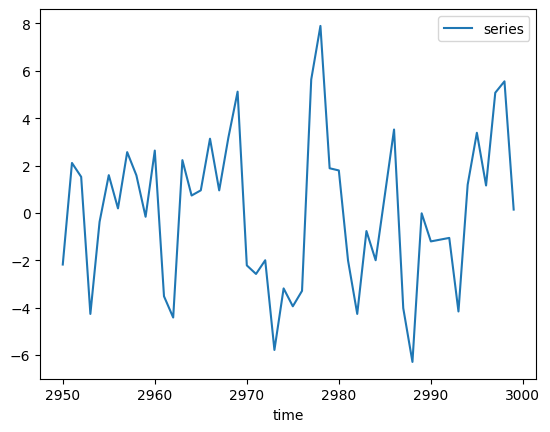

In [2]:
# build univariate time-series data by combining random frequencies
np.random.seed(123)
def ft(t):
    val = 0
    for i in range(8):
        scales = np.random.normal(0, 1, 4)
        val += scales[0] * np.sin(t * scales[1]) + scales[2] * np.cos(t * scales[3])
    return val + np.random.normal(0, 0.1, len(t))

# store as rows in a data frame
n = 3000
time_values = np.arange(n)

# create our data
data = pd.DataFrame({ 
    'series' : ft(time_values),
})

# plot the two time-series
cnt = 50
plt.plot(data.index[-cnt:], data.tail(cnt).series, label='series');
plt.xlabel('time');
plt.legend();

In [3]:
# split the data
training_data, validation_data, test_data = qa.train_val_test_split(data)

# create the driver, this will generate the tensorflow dataset and feed data
driver = qa.Driver(training_data, validation_data, test_data)

# what does our response look like?
head = qa.heads.Regression()

# all the predictors for the model, in this case we only have one
# we will mask out the value in the current row while looking at
# the prior data
predictors = [
    qa.predictors.TimeMaskedPredictor('series')
]

# what is our model architecture? This will store
# our model, driver, and any other information we use in training
# testing, saving, and loading needed for this problem
model = qa.models.RNN('series', head, predictors, driver, time_window=32)

# train the model, we can provide a hyperparameter tuner and other
# training parameters, by default we will use a custom BOHB tuner
model.train(qa.tuners.TunerContainer(qa.tuners.BOHB, max_epochs=30))

Trial 90 Complete [00h 01m 13s]
val_mean_squared_error: 12.544136047363281

Best val_mean_squared_error So Far: 0.7685128450393677
Total elapsed time: 00h 21m 26s
INFO:tensorflow:Oracle triggered exit
Round 1 best score: 0.7191


In [4]:
# evaluate the model on test data
model.evaluate()

3/3 [==============================] - 2s 739ms/step - loss: 0.9156 - mean_squared_error: 0.9156


{'loss': 0.9155682325363159, 'mean_squared_error': 0.9155682325363159}

In [5]:
# save the model to disk and reload the model
# then test on the test data once again
model.save()
model = qa.HyperModel.load()

# evaluate again, this should be the same score as before
model.evaluate()

INFO:tensorflow:Assets written to: ./model\tf_model\assets
3/3 [==============================] - 1s 47ms/step - loss: 0.9156 - mean_squared_error: 0.9156


{'loss': 0.9155682325363159, 'mean_squared_error': 0.9155682325363159}

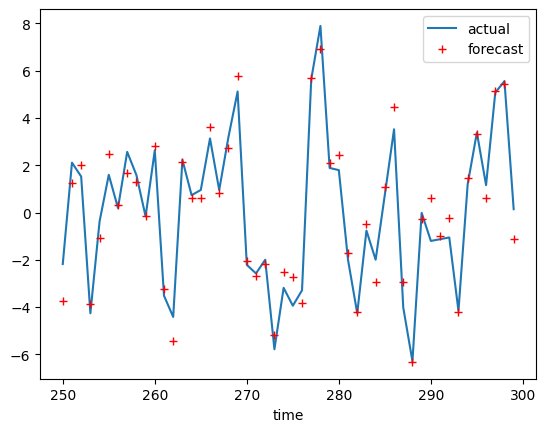

In [6]:
# get predictions on the test
predictions = model.predict(test_data, verbose=0)

# get actuals
actuals = test_data.series

# plot the predictions vs forecast
plt.plot(test_data.index[-cnt:], actuals.tail(cnt), label='actual');
plt.plot(test_data.index[-cnt:], predictions[-cnt:], 'r+', label='forecast');
plt.xlabel('time')
plt.legend();